# Timescale Associations

In [1]:
fmri_data_label = None
dwi_data_label = None
roi_subset = None
results_dir = None
resource_dir = None

In [2]:
# Parameters
dwi_data_label = "Yeh-HCP842"
results_dir = "/home/despo/dlurie/Projects/timescale_hierarchy/results"
resource_dir = "/home/despoB/dlurie/Projects/timescale_hierarchy/data/resources"
fmri_data_label = "NKI-1400_HY_CompCorGSR"
roi_subset = "CX"


In [3]:
import sys
import os
from copy import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from stat import S_IREAD, S_IRGRP, S_IROTH

In [4]:
sys.path.append('/home/despo/dlurie/Projects/timescale_hierarchy/code/scripts/')
sys.path.append('/home/despo/dlurie/Projects/PyPALM/')

In [5]:
import pypalm as pm
import utils

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette("colorblind")
pal = copy(plt.cm.autumn_r)
pal.set_bad('lightgrey')

In [7]:
gamma_range = np.arange(5,36,1) / 10

In [8]:
fc_pc_df, fc_wd_df = utils.load_cartography(f'{results_dir}/functional_connectivity/{fmri_data_label}_BNA_zmat_mean_po_Cartography/', 'MegaPart')
sc_pc_df, sc_wd_df = utils.load_cartography(f'{results_dir}/structural_connectivity/{dwi_data_label}_BNA_log_count_mat_Louvain')
sc_degree_df = pd.read_csv(f'{results_dir}/structural_connectivity/{dwi_data_label}_BNA_degree_df.tsv', delimiter='\t', index_col=0)
fc_degree_df = pd.read_csv(f'{results_dir}/functional_connectivity/{fmri_data_label}_BNA_degree_df.tsv', delimiter='\t', index_col=0)
ts_df = pd.read_csv(f'{results_dir}/timescales/{fmri_data_label}_BNA_timescale_df.csv')
roi_vols = np.genfromtxt(f'{resource_dir}/BNA-maxprob-thr25-2mm_ROI_volumes.txt')

In [9]:
dat = pd.DataFrame(np.array([sc_degree_df.log_count_strength.values,
                             fc_degree_df.strength_zmean_po.values,
                             ts_df.lag1_median.values, roi_vols]).T,
                   columns = ['sc_strength', 'fc_strength', 'lag1', 'roi_vols'])

In [10]:
if roi_subset == 'CX':
    dat = dat[:210]
    
    myelin = np.genfromtxt('/home/despo/dlurie/Projects/timescale_hierarchy/data/hcp/group_average/S1200/HCP-S1200_BNA_myelin.txt')
    myelin_ordered = utils.reorder_BNA_ctx_ROIs(myelin)
    dat['myelin'] = myelin_ordered
    
    corr_thickness = np.genfromtxt('/home/despo/dlurie/Projects/timescale_hierarchy/data/hcp/group_average/S1200/HCP-S1200_BNA_corr_thickness.txt')
    ct_ordered = utils.reorder_BNA_ctx_ROIs(corr_thickness)
    dat['ct'] = ct_ordered
    
    fc_pc_df = fc_pc_df[:210]
    sc_pc_df = sc_pc_df[:210]
    fc_wd_df = fc_wd_df[:210]
    sc_wd_df = sc_wd_df[:210]

In [11]:
lag1_vs_roiv_yhatperm = np.load(f'{results_dir}/stats/timescale_associations/{fmri_data_label}_BNA_{roi_subset}_Lag1_vs_ROIv_yhatperms.npy')

### Functional Connectivity Strength

In [12]:
lag1_vs_fck_rval, lag1_vs_fck_pvals, lag1_vs_fck_model, lag1_vs_fck_rnull = pm.freedman_lane(dat, 'lag1', 'fc_strength', 'roi_vols',
                                                                                             stat='pcorr', n_perms=10000, perm_func=None,
                                                                                             perm_func_args=None, surrogates=lag1_vs_roiv_yhatperm,
                                                                                             return_null=True, return_surrogates=False)

In [13]:
lag1_vs_fck_rval

0.300284605248411

In [14]:
lag1_vs_fck_pvals

p_greater    0.061094
p_less       0.939006
p_abs        0.116388
dtype: float64

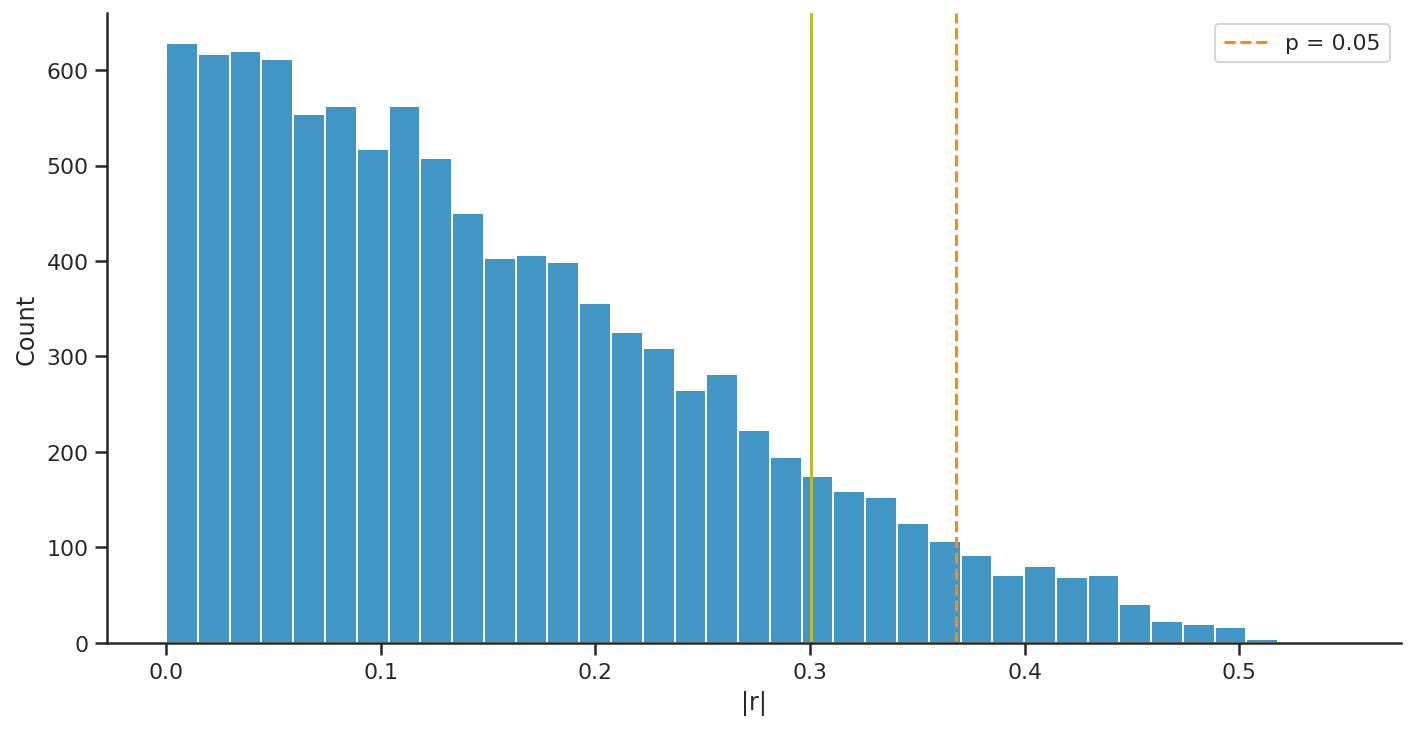

In [15]:
utils.plot_null_hist(lag1_vs_fck_rval, lag1_vs_fck_rnull)

### Structural Connectivity Strength

In [16]:
lag1_vs_sck_rval, lag1_vs_sck_pvals, lag1_vs_sck_model, lag1_vs_sck_rnull = pm.freedman_lane(dat, 'lag1', 'sc_strength', 'roi_vols',
                                                                                             stat='pcorr', n_perms=10000, perm_func=None, 
                                                                                             perm_func_args=None, surrogates=lag1_vs_roiv_yhatperm, 
                                                                                             return_null=True, return_surrogates=False)

In [17]:
lag1_vs_sck_rval

0.2694170611810326

In [18]:
lag1_vs_sck_pvals

p_greater    0.007399
p_less       0.992701
p_abs        0.014299
dtype: float64

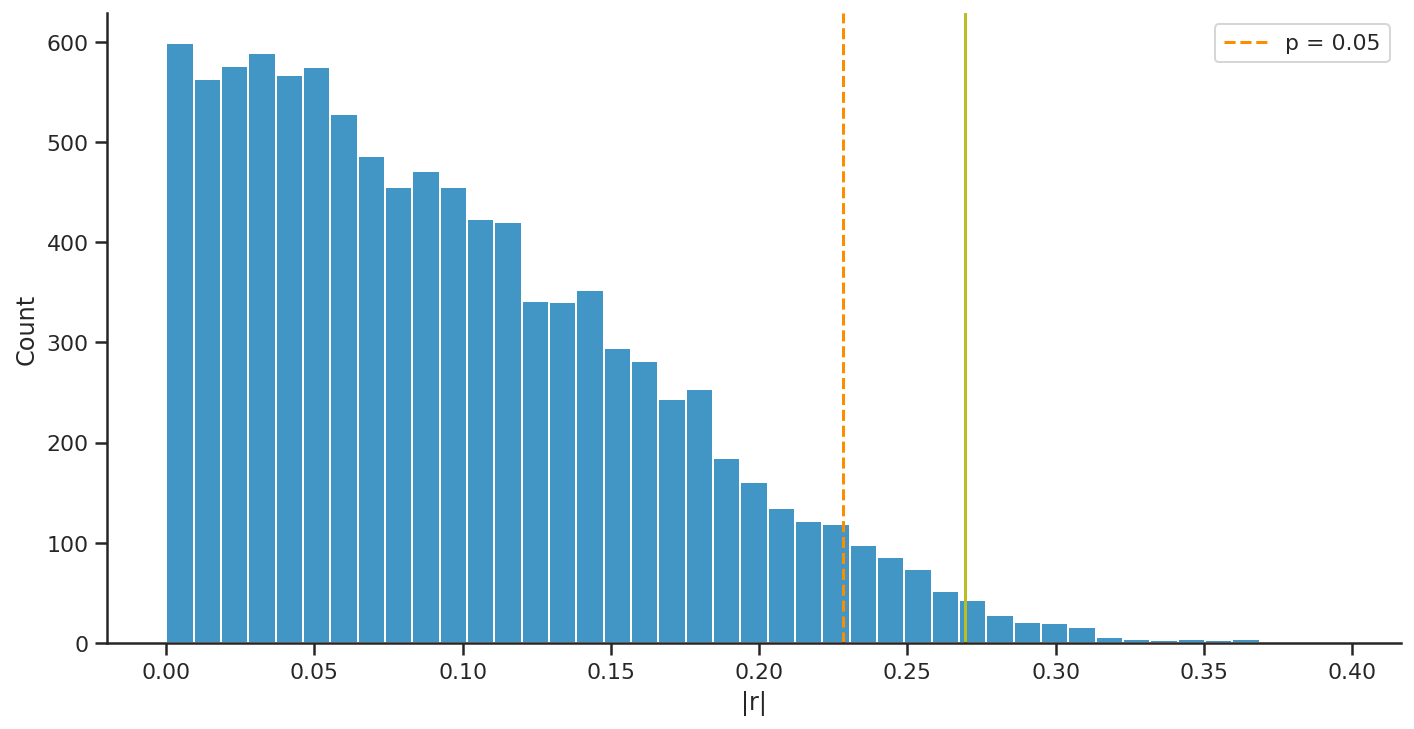

In [19]:
utils.plot_null_hist(lag1_vs_sck_rval, lag1_vs_sck_rnull)

### Functional Connectivitity Within-Module Degree (z-scored)

In [20]:
fc_wd_vs_lag1_df = utils.run_cartography_tests(gamma_range, dat, fc_wd_df, 'lag1', 'fc_wd', 'roi_vols', lag1_vs_roiv_yhatperm)

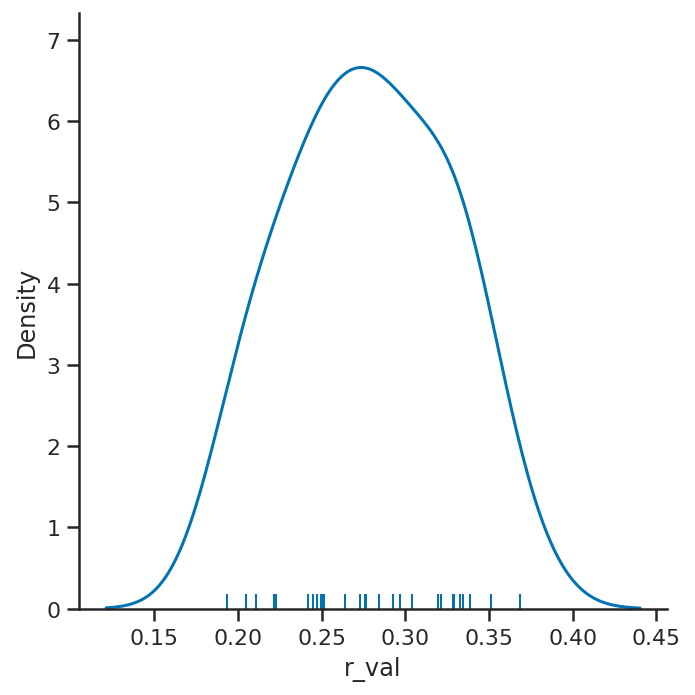

In [21]:
sns.displot(fc_wd_vs_lag1_df.r_val, kind='kde', rug=True)

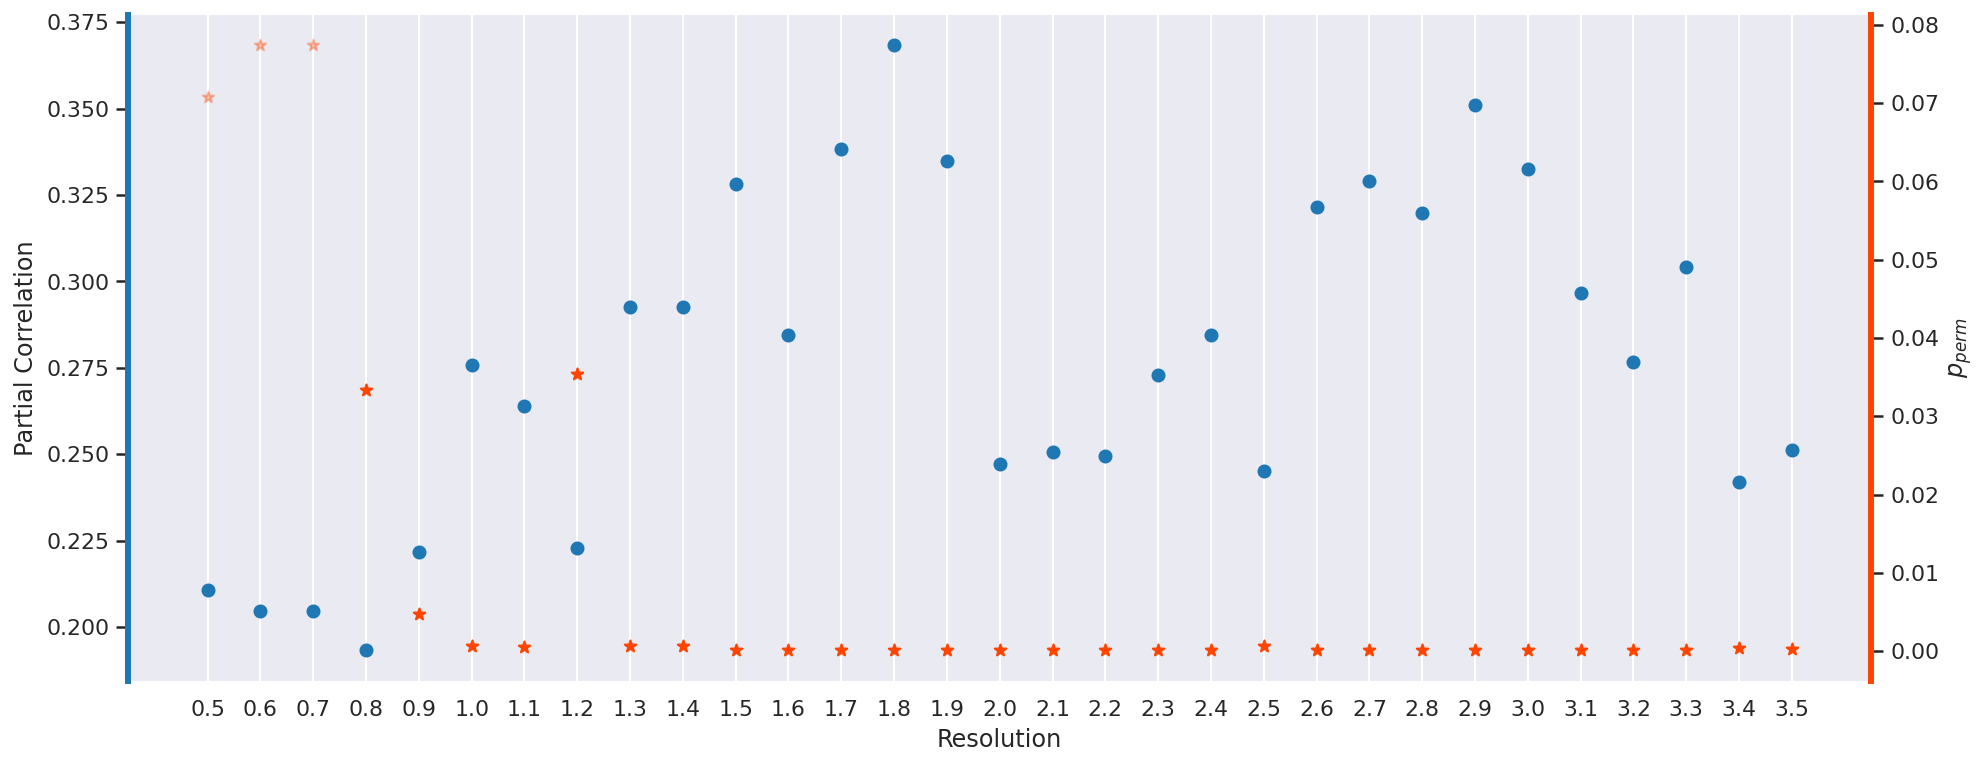

In [22]:
utils.plot_cart_test(fc_wd_vs_lag1_df.gamma, fc_wd_vs_lag1_df.r_val, fc_wd_vs_lag1_df.p_abs)

### Structural Connectivitity Within-Module Degree (z-scored)

In [23]:
sc_wd_vs_lag1_df = utils.run_cartography_tests(gamma_range, dat, sc_wd_df, 'lag1', 'sc_wd', 'roi_vols', lag1_vs_roiv_yhatperm)

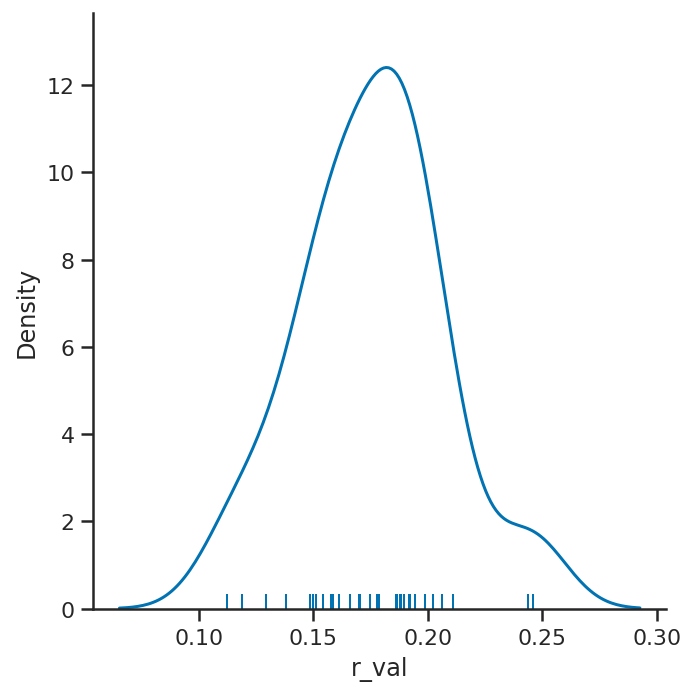

In [24]:
sns.set_style('ticks')
sns.displot(sc_wd_vs_lag1_df.r_val, kind='kde', rug=True)

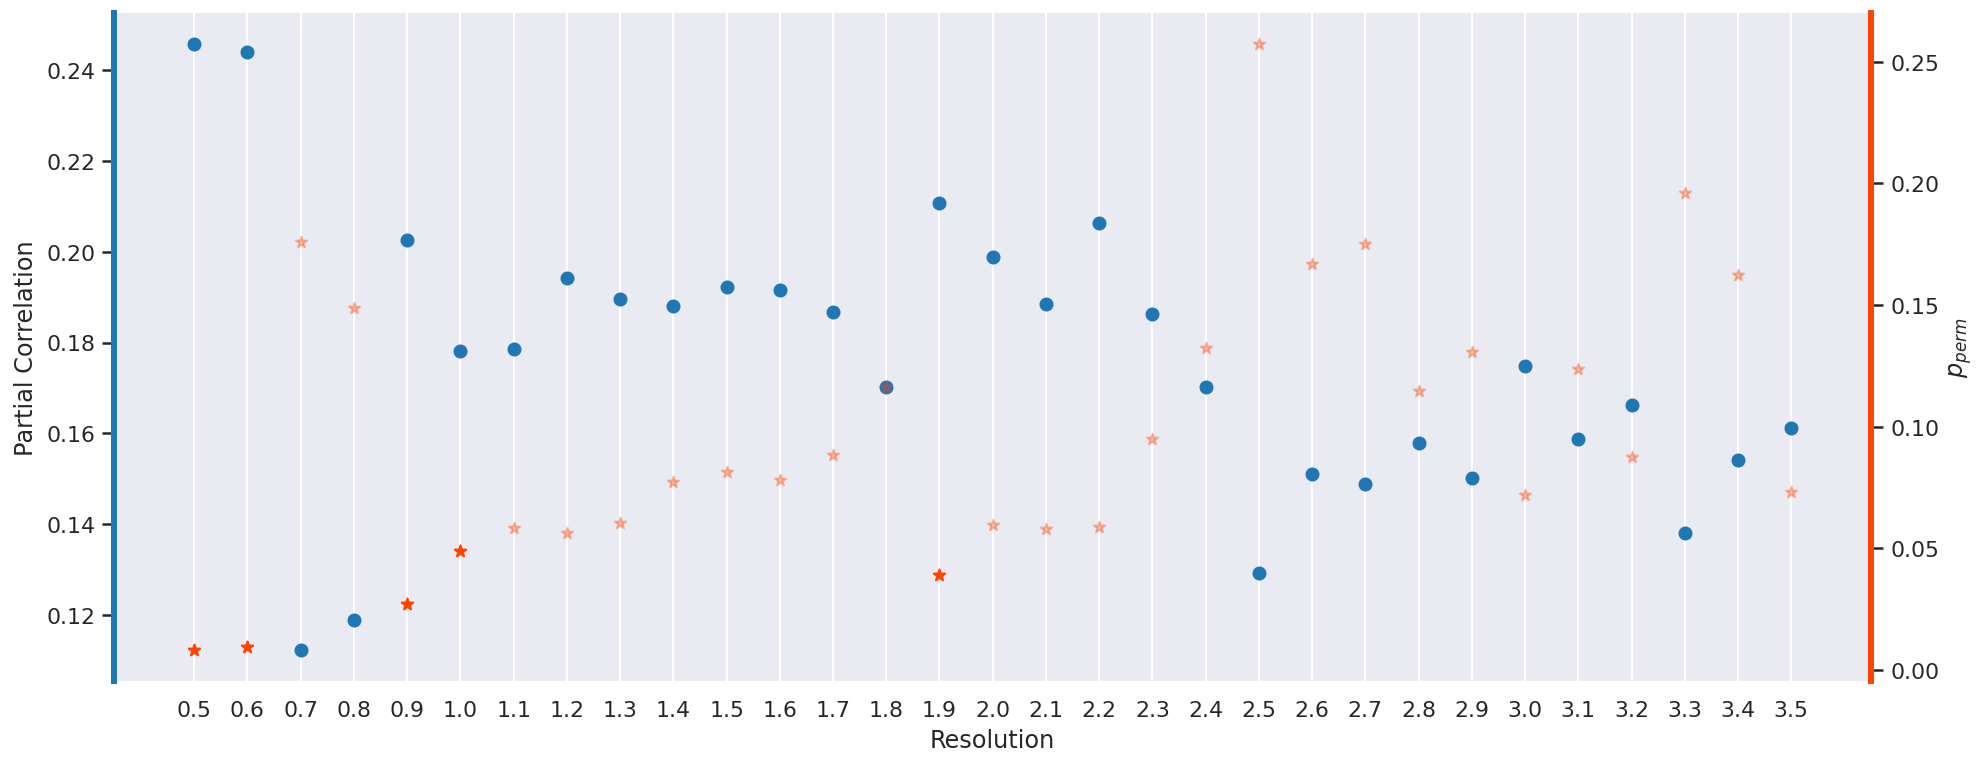

In [25]:
utils.plot_cart_test(sc_wd_vs_lag1_df.gamma, sc_wd_vs_lag1_df.r_val, sc_wd_vs_lag1_df.p_abs)

### Functional Connectivitity Participation Coefficient

In [26]:
fc_pc_vs_lag1_df = utils.run_cartography_tests(gamma_range, dat, fc_pc_df, 'lag1', 'fc_pc', 'roi_vols', lag1_vs_roiv_yhatperm)

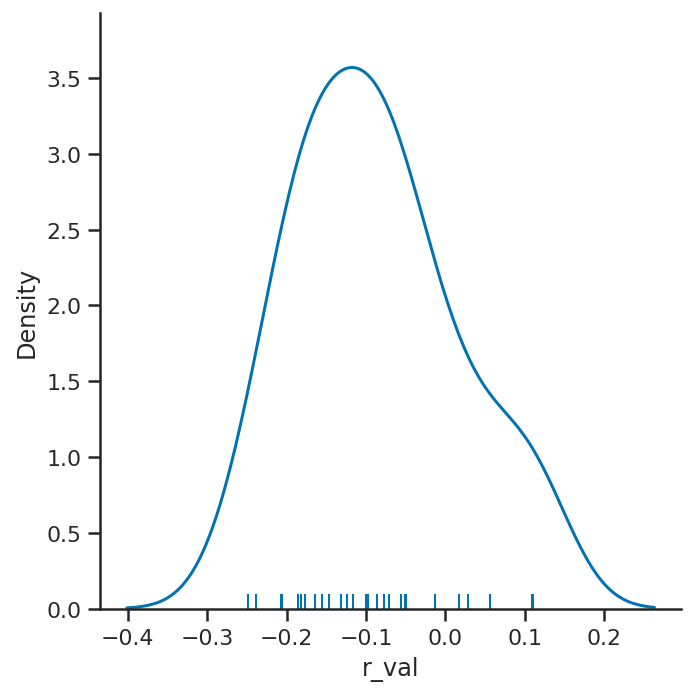

In [27]:
sns.set_style('ticks')
sns.displot(fc_pc_vs_lag1_df.r_val, kind='kde', rug=True)

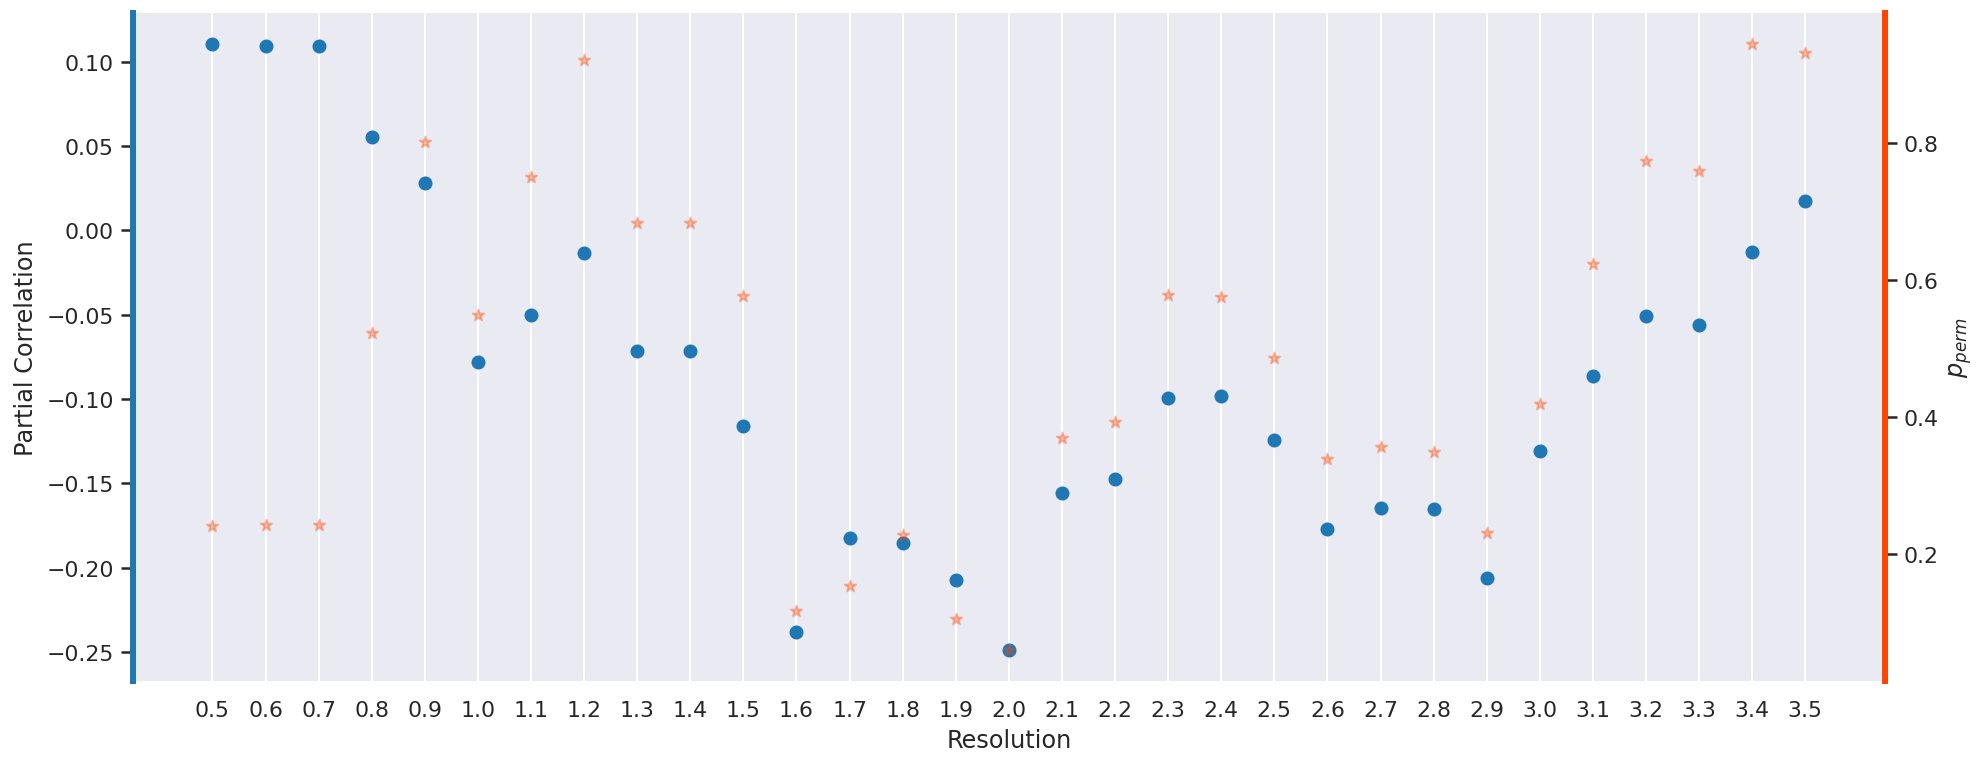

In [28]:
utils.plot_cart_test(fc_pc_vs_lag1_df.gamma, fc_pc_vs_lag1_df.r_val, fc_pc_vs_lag1_df.p_abs)

### Structural Connectivitity Participation Coefficient

In [29]:
sc_pc_vs_lag1_df = utils.run_cartography_tests(gamma_range, dat, sc_pc_df, 'lag1', 'sc_pc', 'roi_vols', lag1_vs_roiv_yhatperm)

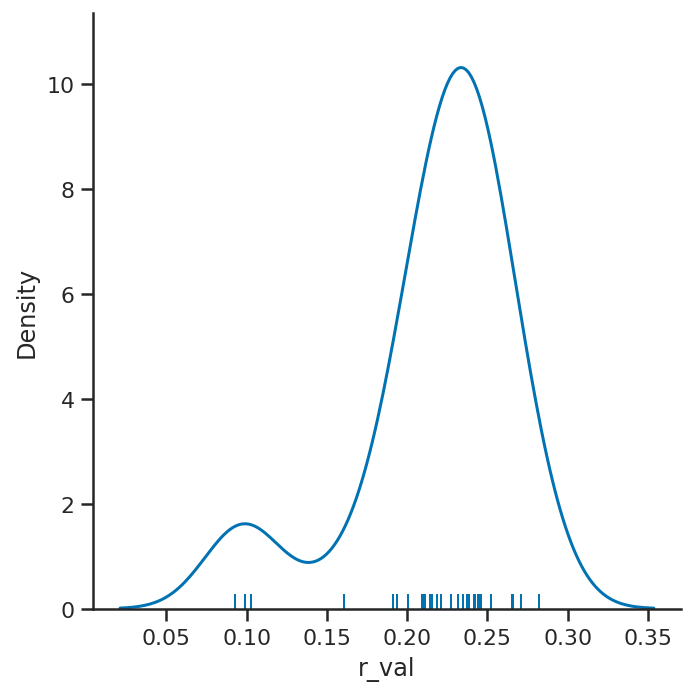

In [30]:
sns.set_style('ticks')
sns.displot(sc_pc_vs_lag1_df.r_val, kind='kde', rug=True)

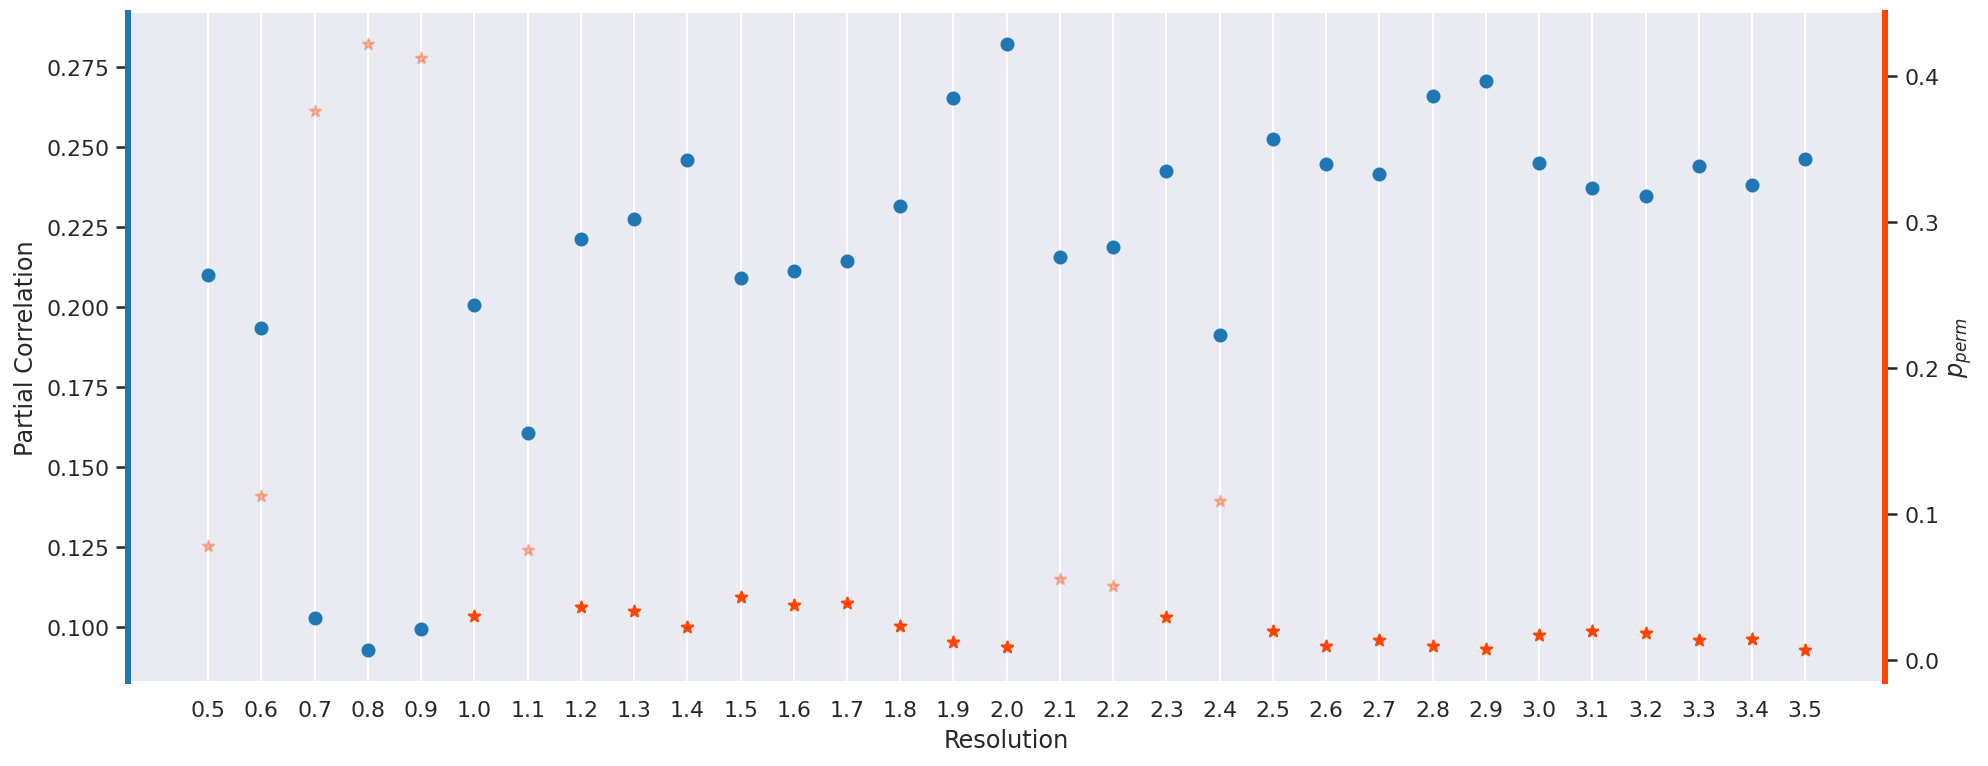

In [31]:
utils.plot_cart_test(sc_pc_vs_lag1_df.gamma, sc_pc_vs_lag1_df.r_val, sc_pc_vs_lag1_df.p_abs)

### T1w/T2w

In [32]:
if roi_subset == 'CX':
    lag1_vs_myelin_rval, lag1_vs_myelin_pvals, lag1_vs_myelin_model, lag1_vs_myelin_rnull = pm.freedman_lane(dat, 'lag1', 'myelin', 'roi_vols',
                                                                                                 stat='pcorr', n_perms=10000, perm_func=None,
                                                                                                 perm_func_args=None, surrogates=lag1_vs_roiv_yhatperm,
                                                                                                 return_null=True, return_surrogates=False)
else:
    print("Not Applicable") 

In [33]:
if roi_subset == 'CX':
    print(lag1_vs_myelin_rval)
else:
    print("Not Applicable")

0.3499366403427744


In [34]:
if roi_subset == 'CX':
    print(lag1_vs_myelin_pvals)
else:
    print("Not Applicable")

p_greater    0.069693
p_less       0.930407
p_abs        0.134887
dtype: float64


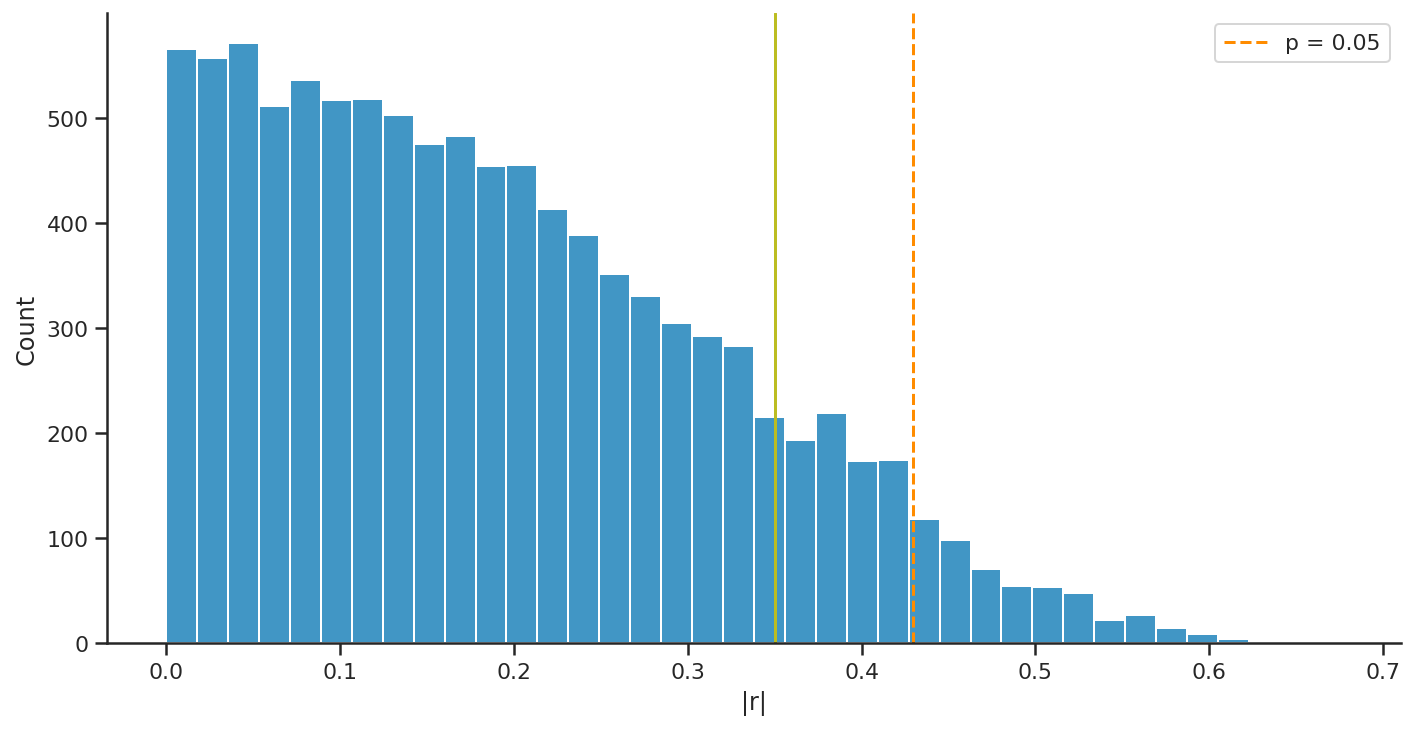

In [35]:
if roi_subset == 'CX':
    utils.plot_null_hist(lag1_vs_myelin_rval, lag1_vs_myelin_rnull)
else:
    print("Not Applicable")

### Cortical Thickness

In [36]:
if roi_subset == 'CX':
    lag1_vs_ct_rval, lag1_vs_ct_pvals, lag1_vs_ct_model, lag1_vs_ct_rnull = pm.freedman_lane(dat, 'lag1', 'ct', 'roi_vols',
                                                                                             stat='pcorr', n_perms=10000, perm_func=None,
                                                                                             perm_func_args=None, surrogates=lag1_vs_roiv_yhatperm,
                                                                                             return_null=True, return_surrogates=False)
else:
    print("Not Applicable")

In [37]:
if roi_subset == 'CX':
    print(lag1_vs_ct_rval)
else:
    print("Not Applicable")

-0.4933134831591426


In [38]:
if roi_subset == 'CX':
    print(lag1_vs_ct_pvals)
else:
    print("Not Applicable")

p_greater    0.996500
p_less       0.003600
p_abs        0.007799
dtype: float64


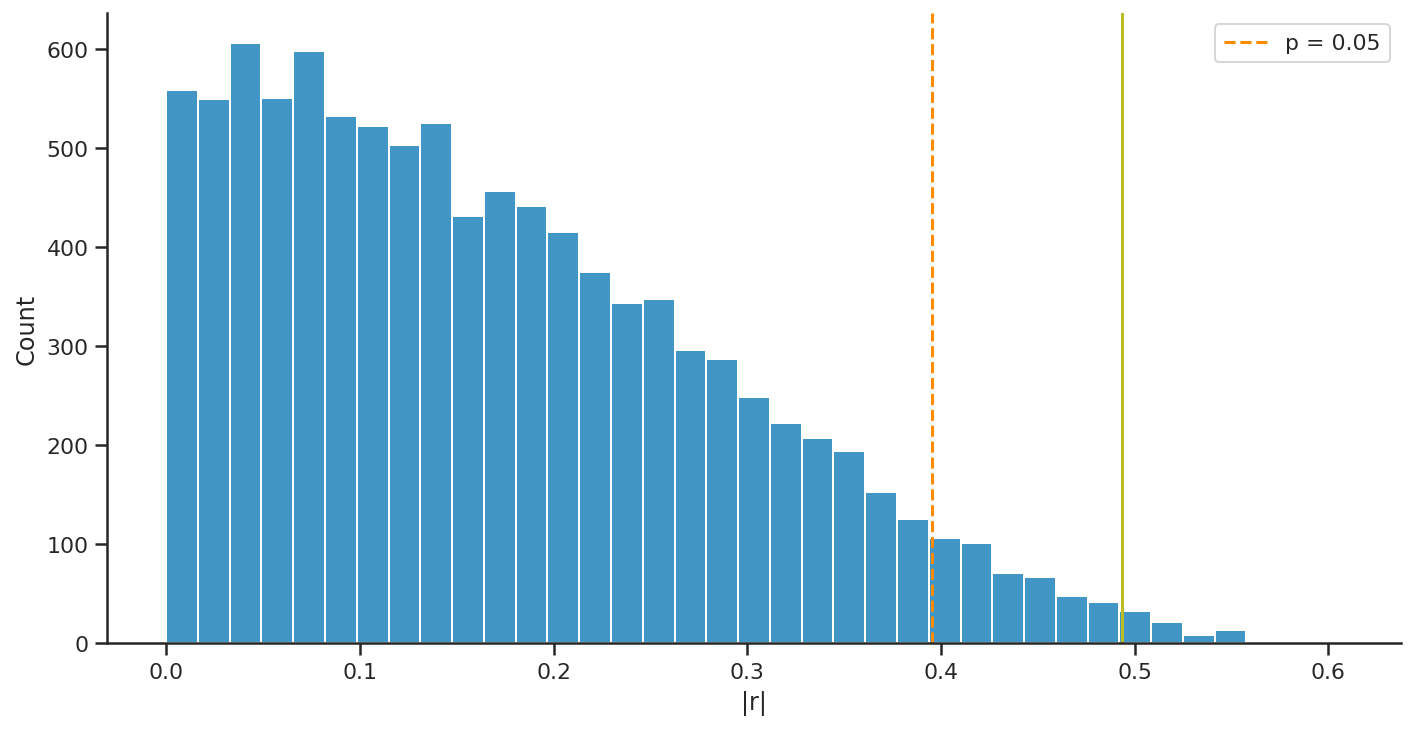

In [39]:
if roi_subset == 'CX':
    utils.plot_null_hist(lag1_vs_ct_rval, lag1_vs_ct_rnull)
else:
    print("Not Applicable")

### Save p-values.

In [40]:
p_other = [lag1_vs_sck_pvals.p_abs, lag1_vs_fck_pvals.p_abs]

if roi_subset == 'CX':
    p_other.append(lag1_vs_myelin_pvals.p_abs)
    p_other.append(lag1_vs_ct_pvals.p_abs)

In [41]:
p_array = np.concatenate((sc_pc_vs_lag1_df.p_abs.values, fc_pc_vs_lag1_df.p_abs.values, sc_wd_vs_lag1_df.p_abs.values,
                          fc_wd_vs_lag1_df.p_abs.values, np.array(p_other)))

In [42]:
p_index = []
for j in ['sc_pc', 'fc_pc', 'sc_wd', 'fc_wd']:
    for i in gamma_range:
        p_index.append(j+'_'+str(i))
p_index.append('sc_strength')
p_index.append('fc_strength')

if roi_subset == 'CX':
    p_index.append('myelin')
    p_index.append('thickness')

In [43]:
p_series = pd.Series(p_array, index=p_index)

In [44]:
p_series.to_csv(f'{results_dir}/stats/{fmri_data_label}_BNA_{roi_subset}_pAbs_df.csv')

### Save partial correlations.

In [45]:
r_other = [lag1_vs_sck_rval, lag1_vs_fck_rval]

if roi_subset == 'CX':
    r_other.append(lag1_vs_myelin_rval)
    r_other.append(lag1_vs_ct_rval)

In [46]:
r_array = np.concatenate((sc_pc_vs_lag1_df.r_val, fc_pc_vs_lag1_df.r_val, sc_wd_vs_lag1_df.r_val,
                          fc_wd_vs_lag1_df.r_val, np.array(r_other)))

In [47]:
r_df = pd.DataFrame(r_array, columns=['r-value'], index=p_index)

In [48]:
out_path = f'{results_dir}/stats/timescale_associations/{fmri_data_label}_BNA_{roi_subset}_pcorr_df.csv'
r_df.to_csv(out_path)
os.chmod(out_path, S_IREAD|S_IRGRP|S_IROTH) # Make results read-only

### Run FDR

In [49]:
q_vals = sm.stats.multipletests(p_series.values, alpha=0.05, method='fdr_bh')[1]

In [50]:
q_df = pd.DataFrame(q_vals, columns=['q-value'], index=p_index)

In [51]:
out_path = f'{results_dir}/stats/timescale_associations/{fmri_data_label}_BNA_{roi_subset}_FDRq_df.csv'
q_df.to_csv(out_path)
os.chmod(out_path, S_IREAD|S_IRGRP|S_IROTH) # Make results read-only

### Summary Plots

In [52]:
non_cart_labels = ['SC Strength', 'FC Strength']

if roi_subset == 'CX':
    non_cart_labels.append('T1w/T2w')
    non_cart_labels.append('Thickness')

In [53]:
annot_df, r_df_cart, annot_df_cart, r_df_other, annot_df_other = utils.prep_summary_plots(q_df, r_df, non_cart_labels)

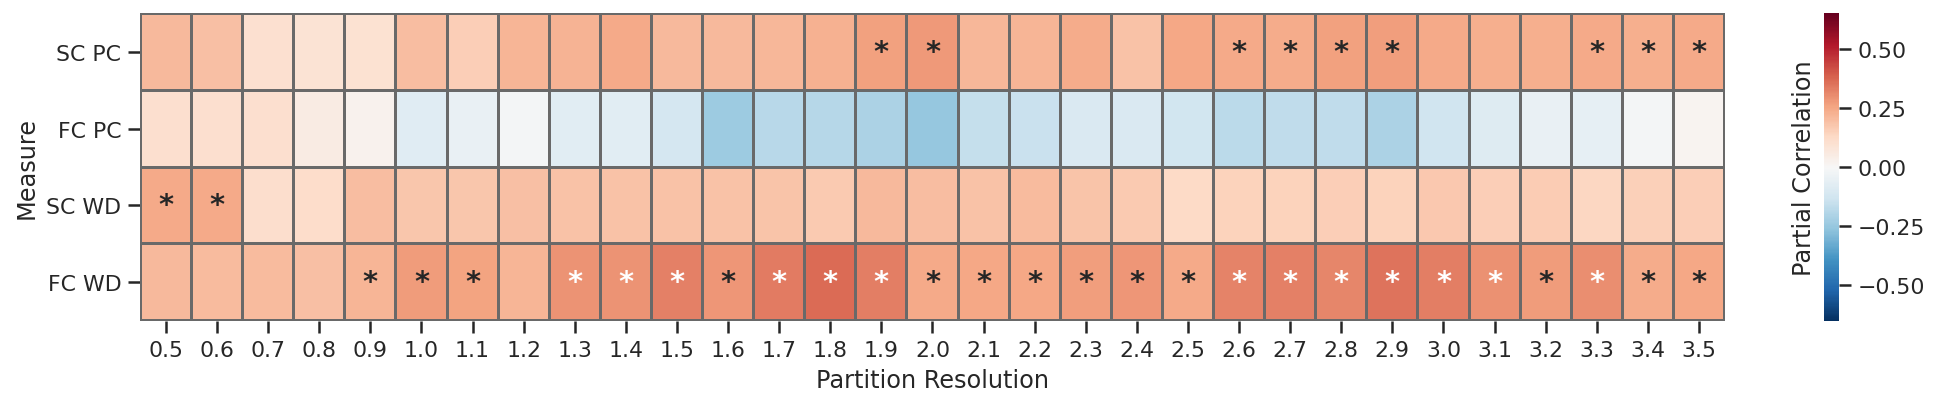

In [54]:
fig, ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(15,3))
sns.heatmap(r_df_cart, cbar=True, linewidths=1, cmap='RdBu_r', vmin=-0.65,
            vmax=0.65, linecolor='dimgrey', ax=ax1, annot=annot_df_cart, 
            fmt='', annot_kws={'fontweight':'black', 'fontsize':'large'}, 
            cbar_kws={'label':'Partial Correlation'})
colorbar = ax1.collections[0].colorbar
colorbar.ax.yaxis.set_label_position('left')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.xlabel('Partition Resolution')
plt.ylabel('Measure')
plt.tight_layout()

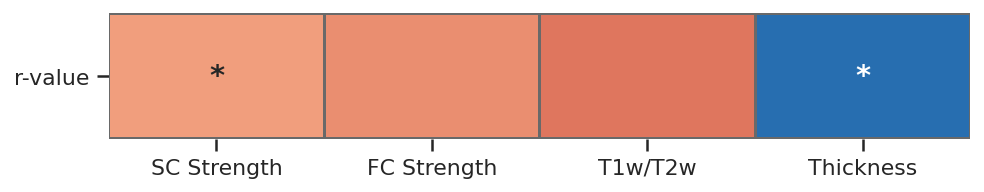

In [55]:
fig, ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(7,1.5))
sns.heatmap(r_df_other.T, cbar=False, linewidths=1, cmap='RdBu_r', vmin=-0.65,
            vmax=0.65, linecolor='dimgrey', ax=ax1, annot=annot_df_other.T,
            fmt='', annot_kws={'fontweight':'black', 'fontsize':'large'})
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()

### Plot Timescale Associations

#### FC K

In [56]:
sns.set_style('ticks')

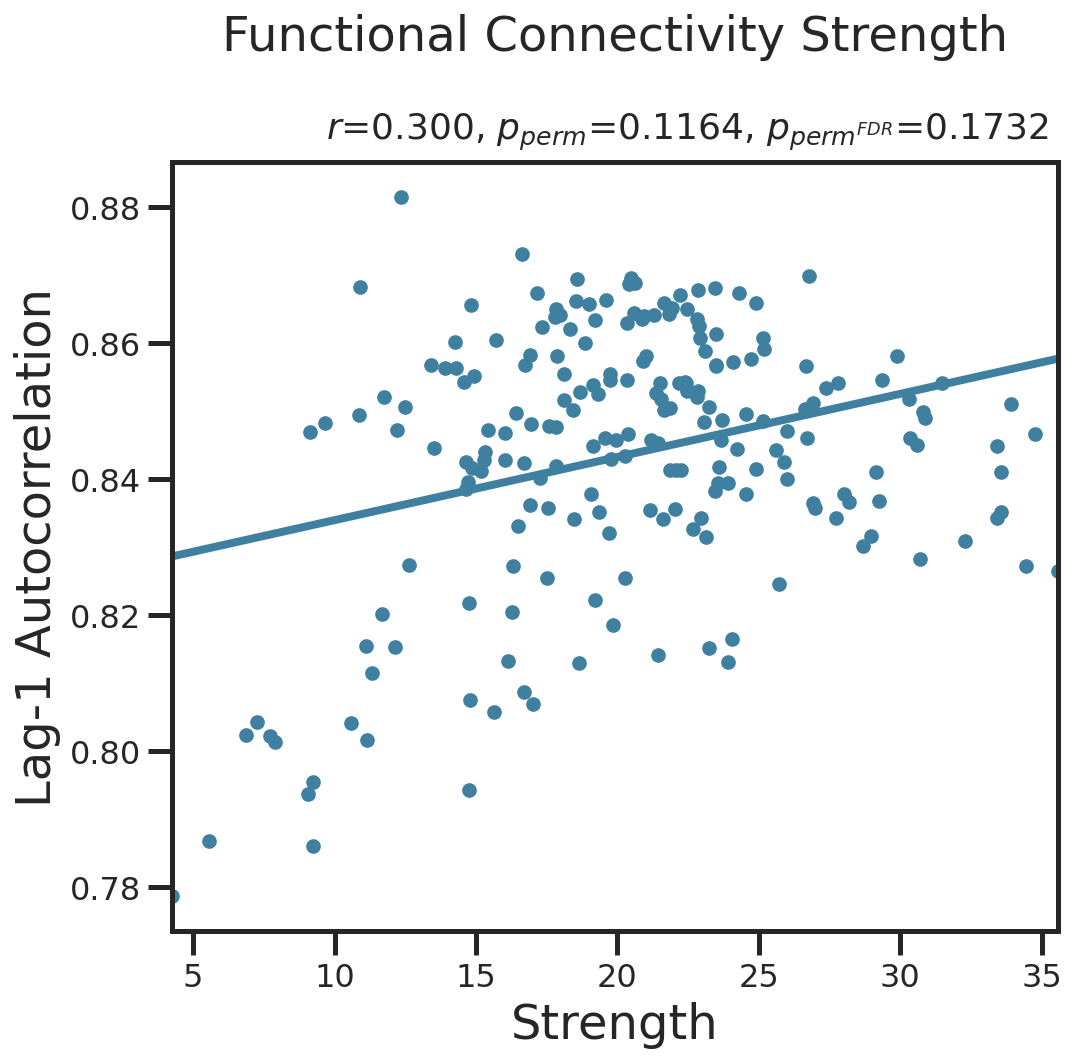

In [57]:
utils.plot_ta_partial(x=dat.fc_strength.values, xlabel='Strength',
                y=dat.lag1.values, ylabel='Lag-1 Autocorrelation',
                covar=dat.roi_vols.values,
                rval=r_df.loc['fc_strength'].values[0],
                pval=p_series.fc_strength, qval=q_df.loc['fc_strength'].values[0],
                color='#3F80A1', title='Functional Connectivity Strength')

#### SC K

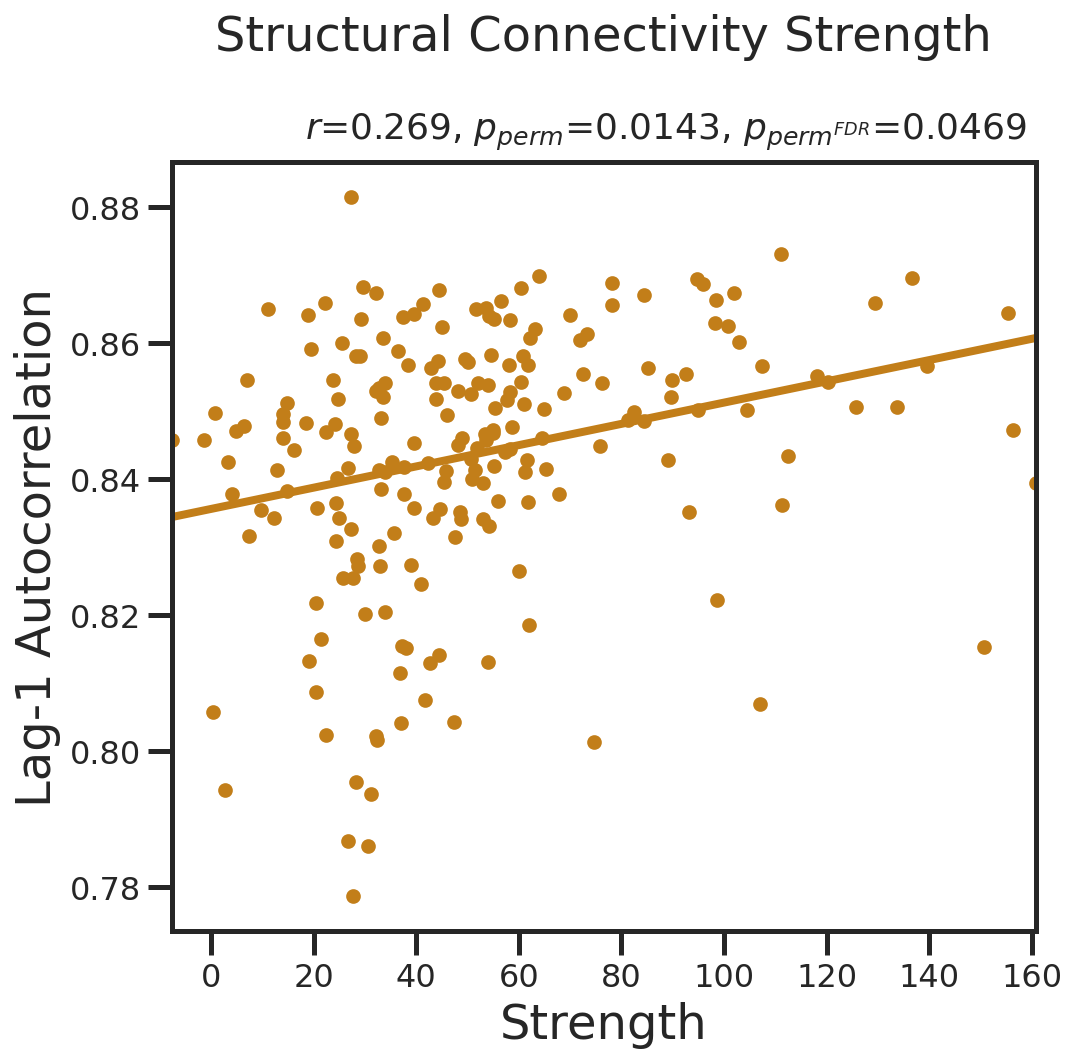

In [58]:
utils.plot_ta_partial(x=dat.sc_strength.values, xlabel='Strength',
                y=dat.lag1.values, ylabel='Lag-1 Autocorrelation',
                covar=dat.roi_vols.values,
                rval=r_df.loc['sc_strength'].values[0],
                pval=p_series.sc_strength, qval=q_df.loc['sc_strength'].values[0],
                color='#C27E19', title='Structural Connectivity Strength')

#### FC PC

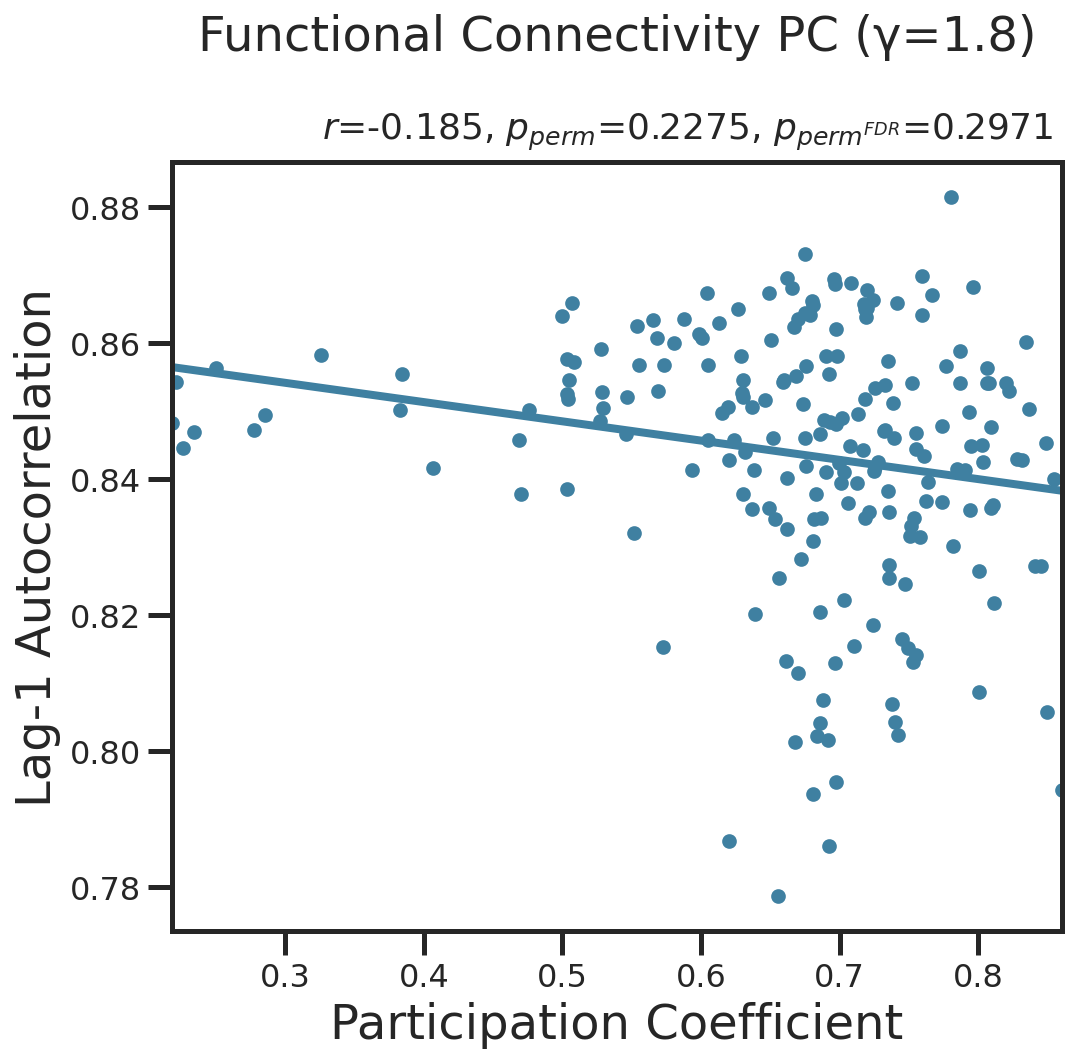

In [59]:
utils.plot_ta_partial(x=fc_pc_df['1.8'].values, xlabel='Participation Coefficient',
                y=dat.lag1.values, ylabel='Lag-1 Autocorrelation',
                covar=dat.roi_vols.values,
                rval=r_df.loc['fc_pc_1.8'].values[0],
                pval=p_series['fc_pc_1.8'], qval=q_df.loc['fc_pc_1.8'].values[0],
                color='#3F80A1', title='Functional Connectivity PC (γ=1.8)')

#### SC PC

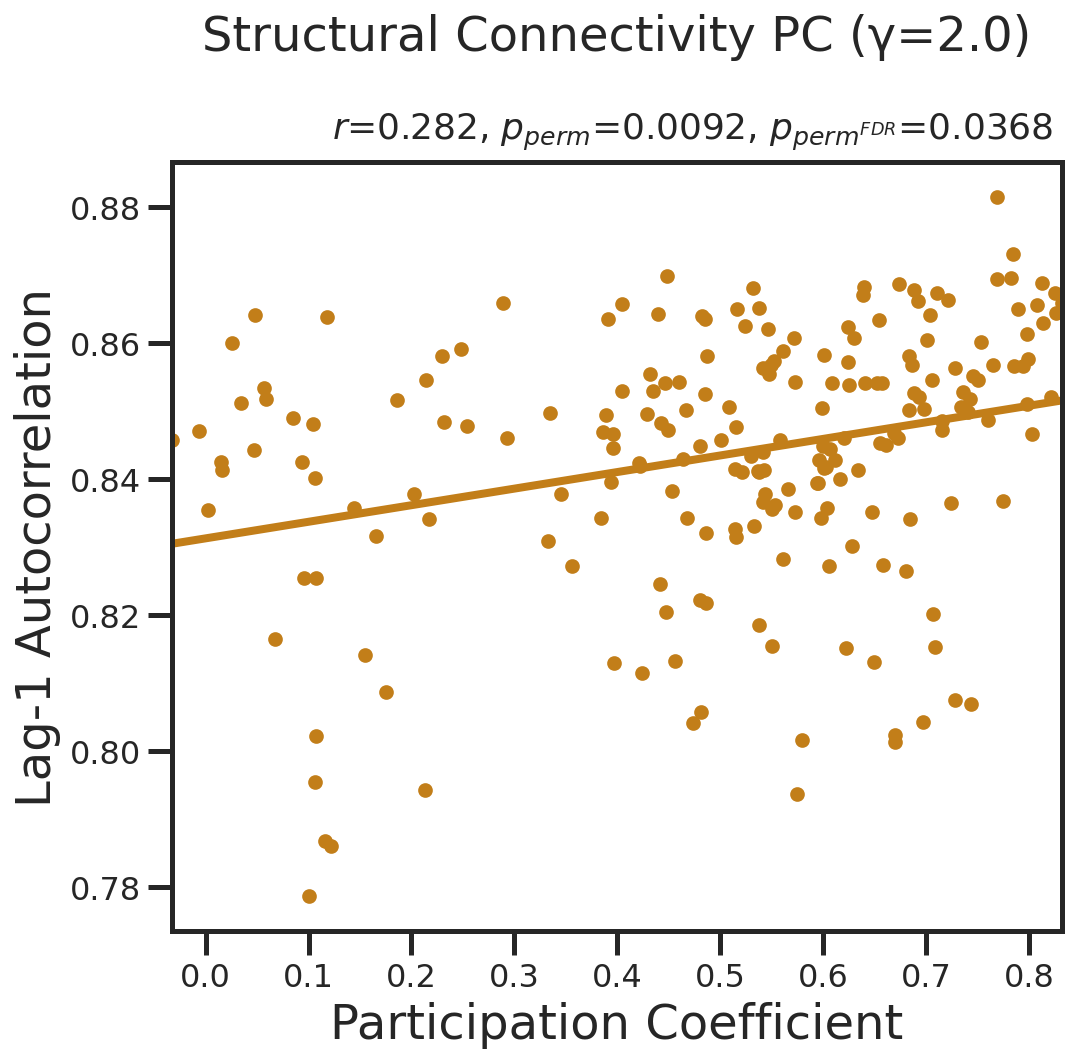

In [60]:
utils.plot_ta_partial(x=sc_pc_df['2.0'].values, xlabel='Participation Coefficient',
                y=dat.lag1.values, ylabel='Lag-1 Autocorrelation',
                covar=dat.roi_vols.values,
                rval=r_df.loc['sc_pc_2.0'].values[0],
                pval=p_series['sc_pc_2.0'], qval=q_df.loc['sc_pc_2.0'].values[0],
                color='#C27E19', title='Structural Connectivity PC (γ=2.0)')

#### FC WD

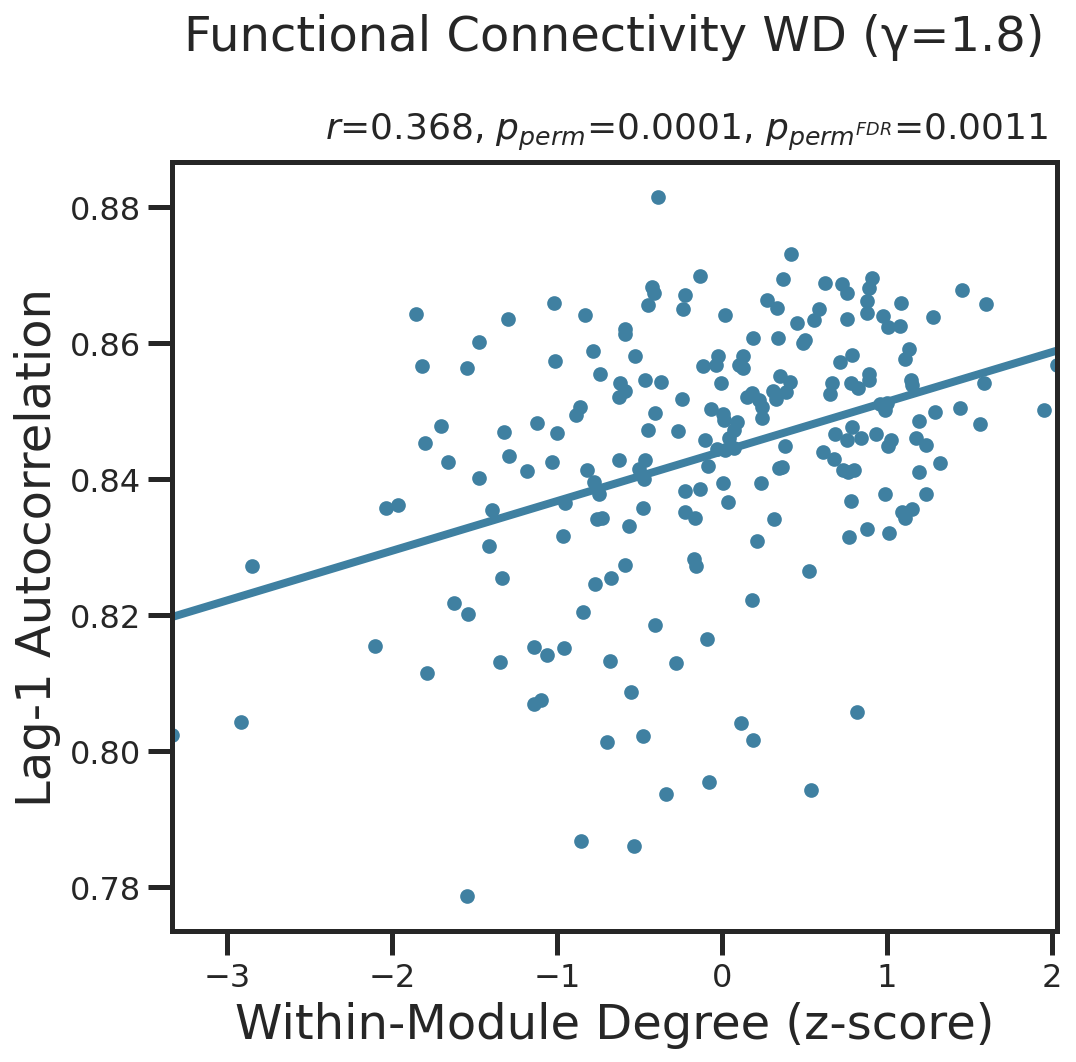

In [61]:
utils.plot_ta_partial(x=fc_wd_df['1.8'].values, xlabel='Within-Module Degree (z-score)',
                y=dat.lag1.values, ylabel='Lag-1 Autocorrelation',
                covar=dat.roi_vols.values,
                rval=r_df.loc['fc_wd_1.8'].values[0],
                pval=p_series['fc_wd_1.8'], qval=q_df.loc['fc_wd_1.8'].values[0],
                color='#3F80A1', title='Functional Connectivity WD (γ=1.8)')

#### SC WD

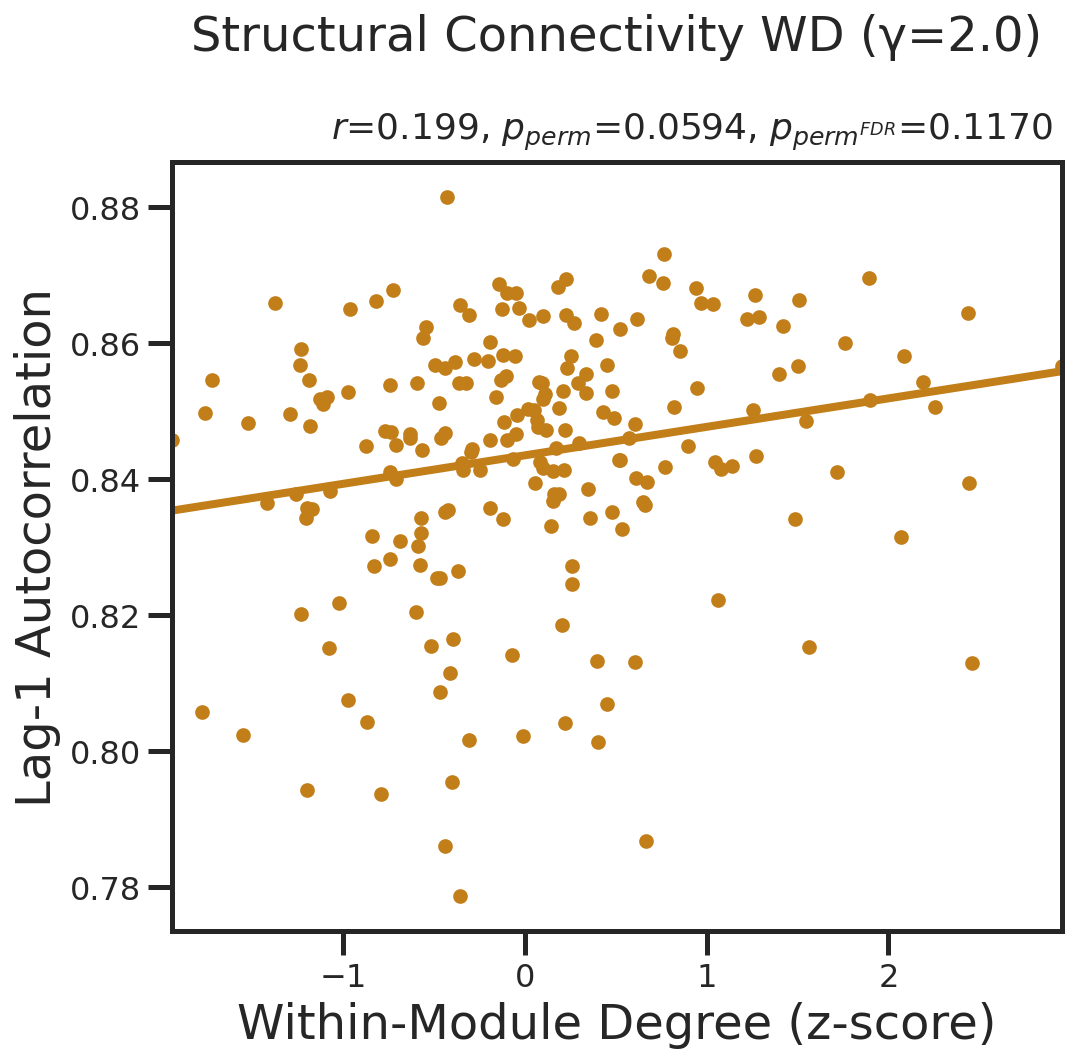

In [62]:
utils.plot_ta_partial(x=sc_wd_df['2.0'].values, xlabel='Within-Module Degree (z-score)',
                y=dat.lag1.values, ylabel='Lag-1 Autocorrelation',
                covar=dat.roi_vols.values,
                rval=r_df.loc['sc_wd_2.0'].values[0],
                pval=p_series['sc_wd_2.0'], qval=q_df.loc['sc_wd_2.0'].values[0],
                color='#C27E19', title='Structural Connectivity WD (γ=2.0)')

#### Cortical Thickness

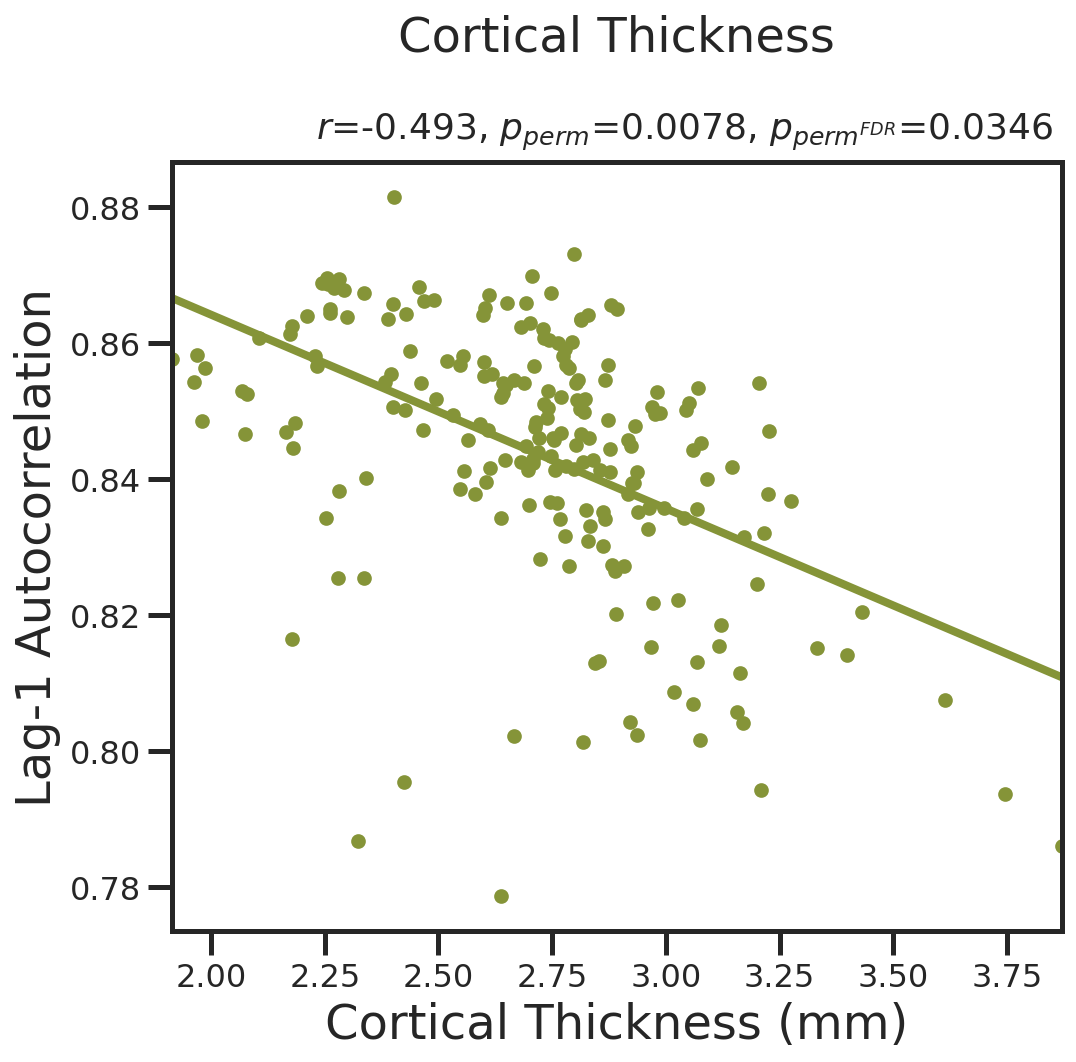

In [63]:
if roi_subset == 'CX':
    utils.plot_ta_partial(x=dat.ct.values, xlabel='Cortical Thickness (mm)',
                    y=dat.lag1.values, ylabel='Lag-1 Autocorrelation',
                    covar=dat.roi_vols.values,
                    rval=r_df.loc['thickness'].values[0],
                    pval=p_series.thickness, qval=q_df.loc['thickness'].values[0],
                    color='#859438', title='Cortical Thickness')
else:
    print('Not Applicable')

#### T1w/T2w MRI

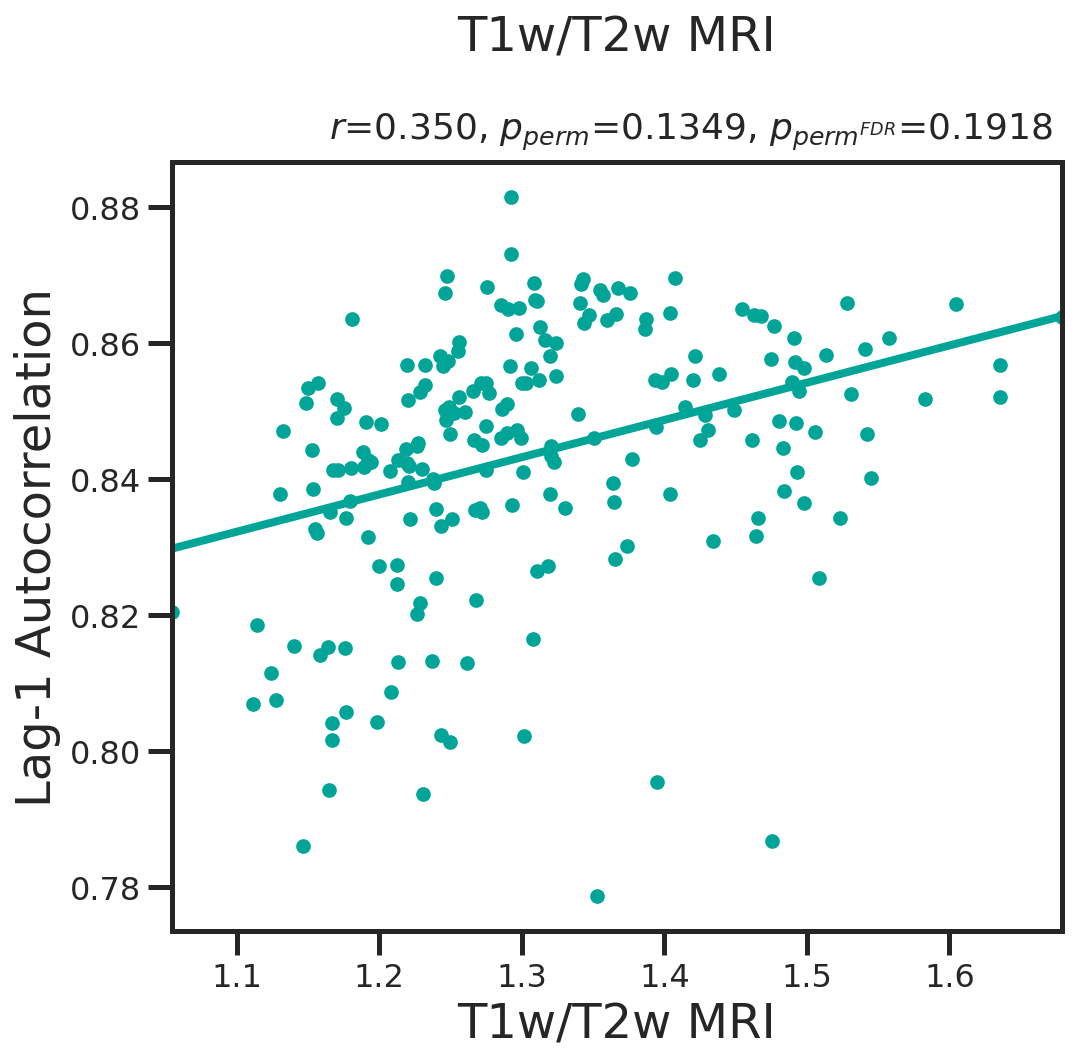

In [64]:
if roi_subset == 'CX':
    utils.plot_ta_partial(x=dat.myelin.values, xlabel='T1w/T2w MRI',
                y=dat.lag1.values, ylabel='Lag-1 Autocorrelation',
                covar=dat.roi_vols.values,
                rval=r_df.loc['myelin'].values[0],
                pval=p_series.myelin, qval=q_df.loc['myelin'].values[0],
                color='#00A598', title='T1w/T2w MRI')
else:
    print('Not Applicable')